In [133]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from google.cloud import bigquery
import time
from sklearn import metrics
from sklearn.metrics import pairwise_distances
import seaborn as sns

# Adress-Merkmal Datensatz erstellen

In [134]:
# %env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json 
# client = bigquery.Client()
# tableName = 'masterarbeit-245718.ethereum_us.top40k_week1777_features'
# query = "SELECT * from `" + tableName+"`"; 
# query_job = client.query(query);
# start = time.time();
# data = query_job.result().to_dataframe();  
# # featureNames = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent', 'avgTimeDiffBetweenSentTransactions', 'avgTimeDiffBetweenReceivedTransactions']
# featureNames = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent']
# featureValues = data.loc[:,featureNames]
# done = time.time();
# elapsed = round(done - start);
# print("Time to retrieve data from BigQuery: {} Seconds.".format(elapsed))
# featureValues

In [135]:
%env GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json 
client = bigquery.Client()
tableName = 'masterarbeit-245718.ethereum_us.features_sampleData'
query = "SELECT * from `" + tableName+"`"; 
query_job = client.query(query);
start = time.time();
data = query_job.result().to_dataframe();  
featureNames = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent', 'avgTimeDiffBetweenSentTransactions', 'avgTimeDiffBetweenReceivedTransactions']
# featureNames = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent']
data = data.set_index("address", drop=True)
featureValues = data.loc[:,featureNames]
done = time.time();
elapsed = round(done - start);
featureValues = featureValues.sort_values(by="weiReceived", ascending=False)
print("Time to retrieve data from BigQuery: {} Seconds.".format(elapsed))

env: GOOGLE_APPLICATION_CREDENTIALS=./secrets/bigquery-service-account.json
Time to retrieve data from BigQuery: 1 Seconds.


In [136]:
featureValues

,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
address,,,,,,
exchange_2,87.0,14.0,8,7,88.000000,72.000000
exchange_3,84.0,15.0,7,7,72.000000,72.000000
exchange_4,80.0,16.0,10,7,78.000000,62.666667
exchange_5,75.0,34.0,8,12,46.909091,70.285714
exchange_1,61.0,29.0,9,10,61.333333,61.500000
speculator_62,10.0,1.0,3,1,936.000000,120.000000
speculator_67,6.0,6.0,2,1,936.000000,48.000000
speculator_78,6.0,0.0,2,0,936.000000,456.000000
speculator_86,5.0,0.0,2,0,936.000000,312.000000


In [137]:
m = data.memory_usage();
totalBytes = m.sum();
totalMegabytes = totalBytes/10**6;
print("Size of the account feature dataset: {} Megabytes.".format(round(totalMegabytes)))

Size of the account feature dataset: 0.0 Megabytes.


# Merkmalsausprägungen standardisieren, so dass Mittelwert und Standardabweichung für alle Merkmale gleich sind 

In [138]:
scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
featureValues_std = scaler.fit_transform(featureValues);
featureValues_std = pd.DataFrame(featureValues_std, columns=featureValues.columns);
featureValues_std.index = featureValues.index
# display(featureValues_std);
len(featureValues_std)

57

# Use Isolationforest to remove outliers

In [139]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(max_samples="auto", behaviour='new', contamination="auto")
clf.fit(featureValues_std)
pred = clf.predict(featureValues_std)
pred = pd.Series(pred)
pred.index = featureValues.index
featureValues_std_out = featureValues_std[pred == 1]
featureValues_out = featureValues[pred == 1]
print("Number of detected and deleted outliers: {}".format(pred.value_counts()[-1]))

Number of detected and deleted outliers: 17


In [140]:
 featureValues[pred == -1]

,weiReceived,weiSent,numberOfTranscationsReceived,numberOfTranscationsSent,avgTimeDiffBetweenSentTransactions,avgTimeDiffBetweenReceivedTransactions
address,,,,,,
exchange_2,87.0,14.0,8,7,88.000000,72.000000
exchange_3,84.0,15.0,7,7,72.000000,72.000000
exchange_4,80.0,16.0,10,7,78.000000,62.666667
exchange_5,75.0,34.0,8,12,46.909091,70.285714
exchange_1,61.0,29.0,9,10,61.333333,61.500000
speculator_62,10.0,1.0,3,1,936.000000,120.000000
speculator_67,6.0,6.0,2,1,936.000000,48.000000
speculator_78,6.0,0.0,2,0,936.000000,456.000000
speculator_63,5.0,0.0,2,0,936.000000,96.000000


# Problem: Isolation forest haut mir die exchanges als gruppe raus. 

# Via Principal Component Analyse die Anzahl der Dimensionen der Datenpunkten für das k-means Clustering Verfahren minimieren 

**Frage:** Wie viel Varianz sollte von der Teilmenge der Principal Components, welche die meiste Varianz erklären, mindestens erklärt werden? Im Folgenden treffe ich die Annahme, dass 90% ausreicht.

In [141]:
minExplainedVariance = 0.9

In [142]:
pca = PCA().fit(featureValues_std)
optimalNumberOfClusters = 0
for i in np.cumsum(pca.explained_variance_ratio_):
    optimalNumberOfClusters = optimalNumberOfClusters + 1
    if i > minExplainedVariance:
        break;

text = "Die {} ersten PCA-Komponenten erklären mehr als {}% der Varianz.".format(optimalNumberOfClusters, minExplainedVariance*100);
display(text)

'Die 2 ersten PCA-Komponenten erklären mehr als 90.0% der Varianz.'

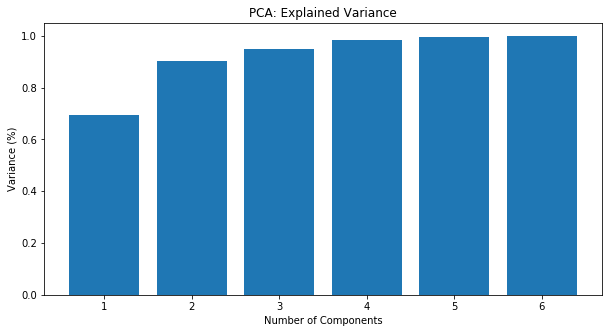

In [143]:
plt.figure(figsize=(10,5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1, 1), np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('PCA: Explained Variance')
plt.show()
plt.close()

In [144]:
pca = PCA(n_components=optimalNumberOfClusters);
featureValues_std_pca = pca.fit_transform(featureValues_std);
featureValues_std_pca = pd.DataFrame(featureValues_std_pca);
featureValues_std_pca.index = featureValues.index
display(featureValues_std_pca);

,0,1
address,,
exchange_2,5.802094,-1.167057
exchange_3,5.592209,-0.917739
exchange_4,6.132659,-1.233625
exchange_5,7.201764,0.670233
exchange_1,6.545050,0.166979
speculator_62,0.470006,-1.973165
speculator_67,0.421307,-1.566552
speculator_78,-0.406671,-1.378541
speculator_86,-0.270645,-1.605565


# Die Anzahl der Cluster bestimmen

**Frage:** Soll ich hier schon die nach PCA transformierten feature values verwenden? Im Folgenden treffe ich die Annahme, dass die nach PCA transformierten feature values verwendet werden sollten.

#### Funktionen

In [145]:
def estimateNumberOfClusters(featureValues, featureValues_std_pca, maxNumberOfClusters):
    scores = []
    numberOfCluster = []

    for i in range(2,maxNumberOfClusters,1):
        kmeans_tmp = KMeans(n_clusters=i)
        kmeans_tmp.fit(featureValues_std_pca)
        numberOfCluster.append(i)
        scores.append(metrics.calinski_harabasz_score(featureValues, kmeans_tmp.labels_))  
    
    result = pd.DataFrame(np.transpose(np.array([numberOfCluster, scores])).astype(int), columns=["Number of Clusters", "C.H. Score"]);
    optimalNumberOfClusters = numberOfCluster[np.argmax(scores)];
    
    return result, optimalNumberOfClusters;

In [146]:
def plotScores(scores):
    plt.figure()
    plt.bar(scores.iloc[:, 0],scores.iloc[:, 1] )
    plt.xlabel('Number of Clusters')
    plt.ylabel('C.H. Score') #for each component
    plt.title('Calinski Harabasz Score')
    plt.show()

In [147]:
scores = []
numberOfCluster = []
maxNumberOfClusters = 10

for i in range(2, maxNumberOfClusters, 1):
    kmeans_tmp = KMeans(n_clusters=i)
    kmeans_tmp.fit(featureValues_std_pca)
    numberOfCluster.append(i)
    scores.append(metrics.calinski_harabasz_score(featureValues, kmeans_tmp.labels_))  

results = pd.DataFrame(zip(numberOfCluster, scores), columns=["number_of_clusters", "calinski_score"])
optimalNumberOfClusters = results.loc[results["calinski_score"].idxmax()].astype(int)["number_of_clusters"]

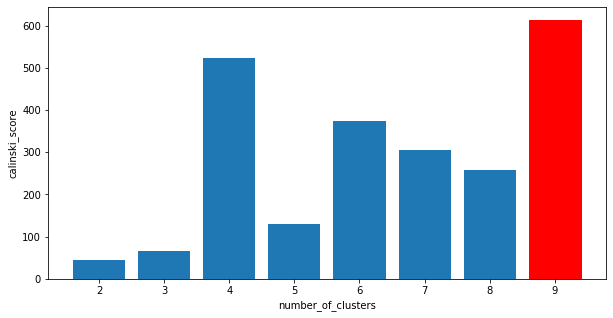

The optimal number of clusters is 9.


In [148]:
plt.figure(figsize=(10,5))
bars = plt.bar(x=results["number_of_clusters"], height=results["calinski_score"])
plt.xlabel(results.columns[0])
plt.ylabel(results.columns[1]) 
bars[results["calinski_score"].idxmax()].set_color("r")
plt.show()
plt.close()
print("The optimal number of clusters is {}.".format(optimalNumberOfClusters))

# Ausreißer eliminieren

**Anmerkung**: *Die Ausreißer entweder im Nachgang eliminieren oder zuvor via Isolation Forest.*

In [149]:

def remove_outliers(featureValues, featureValues_std_pca, kmeans, threshold):
    
    featureValues_std_pca_within_cluster_new = pd.DataFrame();
    featureValues_within_cluster_new = pd.DataFrame();
    labels_new = [];

    for clusterNumber, centroid in enumerate(kmeans.cluster_centers_):
        
        featureValues_std_pca_within_cluster = featureValues_std_pca[kmeans_opt.labels_ == clusterNumber];
        featureValues_within_cluster = featureValues[kmeans_opt.labels_ == clusterNumber];
            
        distances = featureValues_std_pca_within_cluster - centroid;
        distances_norm = np.linalg.norm(distances, axis=1);

        maxDistance = threshold * np.linalg.norm(featureValues_std_pca_within_cluster.std())
        
        keep = distances_norm <= maxDistance
        
        featureValues_std_pca_within_cluster_new = featureValues_std_pca_within_cluster_new.append(featureValues_std_pca_within_cluster[keep])
        featureValues_within_cluster_new = featureValues_within_cluster_new.append(featureValues_within_cluster[keep])
        labels_new.extend([clusterNumber for i in featureValues_within_cluster[keep].iterrows()])
        
    return featureValues_std_pca_within_cluster_new, featureValues_within_cluster_new, labels_new

In [150]:
# kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
# kmeans_opt.fit(featureValues_std_pca)

In [151]:
# from sklearn.metrics import calinski_harabaz_score as ch_score

# thresholds = np.linspace(.01,3, 20)

# test = [remove_outliers(featureValues, featureValues_std_pca, kmeans_opt,t) for t in thresholds]

# scores= []

# for (res1, res2, labels) in test:
#     scores.append(metrics.calinski_harabasz_score(res2, labels)) 

In [152]:
# plt.plot(thresholds, scores)
# plt.title('Calinski Harabaz Scores as std threshold changes')

In [153]:
# optimalThreshold = thresholds[np.argmax(scores)]
# print("The threshold leading to the highest Calinski Harabaz Score is", optimalThreshold)

In [154]:
# featureValues, featureValues_std_pca, labels = remove_outliers(featureValues, featureValues_std_pca, kmeans_opt, optimalThreshold)
# featureValues_std_pca = pd.DataFrame(featureValues_std_pca)
# featureValues = pd.DataFrame(featureValues)

# Visualisierung: T-SNE

In [155]:
# from sklearn.manifold import TSNE

# time_start = time.time()

# tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=500)
# featureValues_std_pca_out_tsne = tsne.fit_transform(featureValues_std_pca_out)
# featureValues_std_pca_out_tsne = pd.DataFrame(featureValues_std_pca_out_tsne, columns=["1_tsne_comp","1_tsne_comp"])
# featureValues_std_pca_out_tsne.head()

# print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

In [156]:
# # Plot Digits t-SNE
# import seaborn as sns

# # Set style of scatterplot
# sns.set_context("notebook", font_scale=1.1)
# sns.set_style("ticks")

# featureValues_std_pca_out_tsne["Label"] = kmeans_opt.labels_
# featureValues_std_pca_out_tsne.columns = ["x", "y", "Label"]

# sns.lmplot(x='x',
#            y='y',
#            data=featureValues_std_pca_out_tsne,
#            fit_reg=False,
#            legend=True,
#            height=9,
#            hue='Label',
#            scatter_kws={"s":200, "alpha":0.3})


# plt.title('t-SNE Results:', weight='bold').set_fontsize('14')
# plt.xlabel('Prin Comp 1', weight='bold').set_fontsize('10')
# plt.ylabel('Prin Comp 2', weight='bold').set_fontsize('10')

## Visualisierung PCA 3D Diagramm

In [157]:
# from mpl_toolkits.mplot3d import Axes3D
# # To getter a better understanding of interaction of the dimensions
# # plot the first three PCA dimensions
# fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig, elev=-150, azim=110)
# X_reduced = PCA(n_components=3).fit_transform(featureValues_out)
# ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_,
#            cmap=plt.cm.Set1, edgecolor='k', s=40)
# ax.set_title("First three PCA directions")
# ax.set_xlabel("1st eigenvector")
# ax.w_xaxis.set_ticklabels([])
# ax.set_ylabel("2nd eigenvector")
# ax.w_yaxis.set_ticklabels([])
# ax.set_zlabel("3rd eigenvector")
# ax.w_zaxis.set_ticklabels([])

In [164]:
# optimalNumberOfClusters = 2 # tmp
kmeans_opt = KMeans(n_clusters=optimalNumberOfClusters)
kmeans_opt.fit(featureValues_std_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [159]:
kmeans_opt.labels_

array([2, 2, 2, 6, 6, 3, 3, 8, 8, 3, 8, 5, 8, 4, 4, 5, 5, 5, 8, 5, 5, 5,
       7, 5, 4, 4, 1, 3, 0, 5, 1, 1, 1, 5, 5, 1, 4, 5, 4, 7, 1, 1, 1, 1,
       0, 1, 1, 1, 7, 7, 1, 4, 1, 1, 5, 4, 4], dtype=int32)

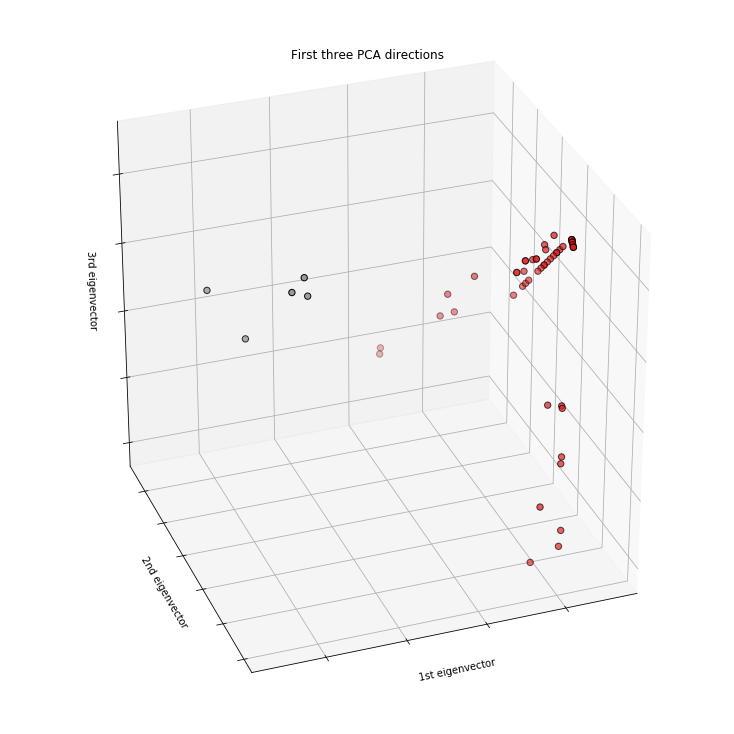

In [165]:
from mpl_toolkits.mplot3d import Axes3D;
# To getter a better understanding of interaction of the dimensions;
# plot the first three PCA dimensions;
fig = plt.figure(figsize=(10, 10));
ax = Axes3D(fig, elev=-150, azim=110);

scaler = StandardScaler(copy=True, with_mean=True, with_std=True);
featureValues_std = scaler.fit_transform(featureValues);
featureValues_std = pd.DataFrame(featureValues_std, columns=featureValues.columns);
X_reduced = PCA(n_components=3).fit_transform(featureValues_std);


ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=kmeans_opt.labels_, cmap=plt.cm.Set1, edgecolor='k', s=40);
ax.set_title("First three PCA directions");
ax.set_xlabel("1st eigenvector");
ax.w_xaxis.set_ticklabels([]);
ax.set_ylabel("2nd eigenvector");
ax.w_yaxis.set_ticklabels([]);
ax.set_zlabel("3rd eigenvector");
ax.w_zaxis.set_ticklabels([]);

# Visualisierung: Vergleich der Ballungen

Length of cluster 0 is 52
Length of cluster 1 is 5


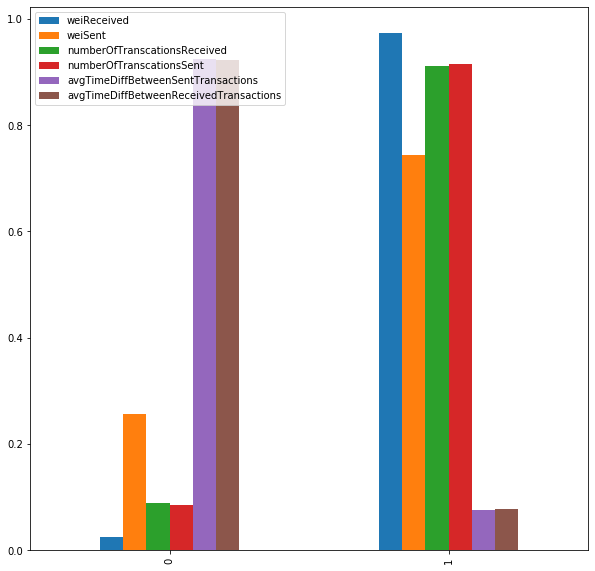

In [167]:
clusterMeans = []
for i, center in enumerate(kmeans_opt.cluster_centers_):
    print("Length of cluster {} is {}".format(i, len(featureValues[kmeans_opt.labels_==i])))
    within_cluster_featureValues = featureValues[kmeans_opt.labels_==i]
#     display(within_cluster_featureValues)
#     within_cluster_featureValues.columns = ['weiReceived', 'weiSent', 'numberOfTranscationsReceived', 'numberOfTranscationsSent']
    clusterMeans.append(within_cluster_featureValues.mean())

x = pd.DataFrame(clusterMeans)
x.sum()
x = x / x.sum()
x.plot(kind="bar", figsize=(10,10))

In [ ]:
featureValues

Problem: Das ergibt keinen Sinn. Die accounts welche sich am meisten Zeit zwischen 2 Transaktionen im Schnitt lassen, haben die mehr Transaktionen abgeschickt, als die accounts welche sich weniger Zeit lassen. Vllt erstmal clustering betreiben ohne die avg time? 

Problem: Warum ist weiSent und weiReceived so ähnlich? Das macht doch auch keinen SInn ? Vllt sind auch diese Daten falsch. Am besten aus dem Internet einen sql command zur Bestimmung der Balance nehmen.

In [131]:

# number of variable
categories=list(x)
N = len(categories)

# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values1 = x.loc[0].values.tolist()
values1 += values[:1]
values2 = x.loc[1].values.tolist()
values2 += values[:1]
    
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
angles
 
plt.figure(figsize=(10,10))


# Initialise the spider plot
ax1 = plt.subplot(211, polar=True)
    
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax1.set_rlabel_position(0)
plt.yticks([0,0.5,1], ["0","0.5","1"], color="grey", size=7)
 
# Plot data
ax1.plot(angles, values1, linewidth=1, linestyle='solid')
 
# Fill area
ax1.fill(angles, values1, 'b', alpha=0.1)


# Initialise the spider plot
ax2 = plt.subplot(212, polar=True)
    
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories)
 
# Draw ylabels
ax2.set_rlabel_position(0)
plt.yticks([0,0.5,1], ["0","0.5","1"], color="grey", size=7)
 
# Plot data
ax2.plot(angles, values2, linewidth=1, linestyle='solid')
 
# Fill area
ax2.fill(angles, values2, 'b', alpha=0.1, color="green")


NameError: name 'values' is not defined

# Verifiziere das Funktionieren des Entscheidungsmodells mit bekannten Adressen

# Temporary stuff